In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import scipy as sp
import pandas as pd
import pickle

import path
path.path = path.Path
from pyqt_fit import kde,kde_methods

Warning, cannot import Cython kernel functions, pure python functions will be used instead


### Let's analyze the obliquity of VHS1256


break-up velocity = Fuerza Centrifuga vs Gravitacional

In [2]:
VHS_mass   = 19    * u.Mjup     # +/- 5
VHS_inc_o  = 118.7              # +/- 1 deg
VHS_rad    = 1.17   * u.Rjup
VHR_vsini  = 13.5  *(u.km/u.s)  # +3.6 /-4.1
VHR_period = 22.04 * u.hr       # +- 0.05

In [3]:
vel_breakup = np.sqrt(c.G * VHS_mass / (VHS_rad))
vel_breakup = vel_breakup.to(u.km/u.s)

print('V_breakup = '+ str(vel_breakup))

print('VHR1256 is orbiting at {:0.1f}% of its break-up velocity'.format(100*VHR_vsini/vel_breakup))

V_breakup = 169.63691532358976 km / s
VHR1256 is orbiting at 8.0% of its break-up velocity


### Spin inclination and true obliquity

The rotation period of VHR1256 is ~ 22 hr.

Since there is already a reliable estimation on the rotation period, we go for the obliquity of the planet, given the vsini value and the P_rotation.

Following the procedure showed in Bryan et al. (2021), section 3.5.

https://doi.org/10.3847/1538-3881/ac1bb1

VHR1256 break-up period is 0.9 h


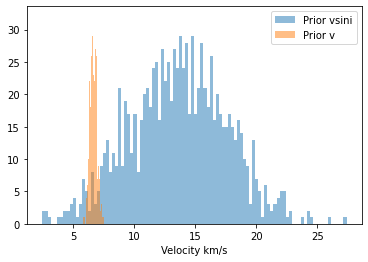

In [4]:
# Gaussian distributions
sizen = 1000
prior_radius = np.random.normal(loc=VHS_rad.value, scale=0.05, size=sizen)* u.Rjup
prior_vsini  = np.random.normal(loc=VHR_vsini.value, scale=4, size=sizen)* u.km / u.s
prior_v = (2*np.pi*prior_radius / VHR_period ).to(u.km/u.s) 

# break-up period (s)
pb       = (2*np.pi*(VHS_rad**(3/2))      / np.sqrt(c.G* VHS_mass)).to(u.hr)
prior_pb = (2*np.pi*(prior_radius**(3/2)) / np.sqrt(c.G* VHS_mass)).to(u.hr)
print('VHR1256 break-up period is {:0.1f}'.format(pb))


plt.hist(prior_vsini.value, alpha=0.5, bins=100,label='Prior vsini')
plt.hist(prior_v.value, alpha=0.5, bins=100, label='Prior v')
plt.legend()
plt.xlabel('Velocity km/s')
plt.show()



In [5]:
#pb, prior_pb, sample

Removing solutions above the break-up velocity

Here we implement the equation 10 of Bryan et al. 2021

In [21]:
def planet_inclination(pdf_lu, pdf_lv, pdf_Pv, pdf_Pcos, nv=100):
    '''
    Function that integrates the curve for p(cos(i))

    Inputs:
    pdf_lu   :
    pdf_lv   :
    pdf_Pv   :
    pdf_Pcos :
    nv       : (=100 default) number of integration steps 

    Outputs:

    '''
    # create array with angles distribution
    angles = np.linspace(0, np.pi, nv)

    # array with zeros to save outcomes of the integration for each angle step
    pcosi = np.zeros_like(angles) # PDF of cos(ip)

    # integrate in velocity
    for j, ci in enumerate(np.cos(angles)):
        int_dv = pdf_lv(vrange) * pdf_lu(vrange*np.sqrt(1-ci*ci)) * pdf_Pv(vrange)
        pcosi[j] = np.trapz(int_dv, vrange)

    # multiply by the pdf of the cos(i) outside of the integral
    curve_pcosi = pdf_Pcos(angles)*pcosi
    
    return angles, pcosi, curve_pcosi

Size initial sample = 1000
Size new sample = 44 (vsini < v < vb)


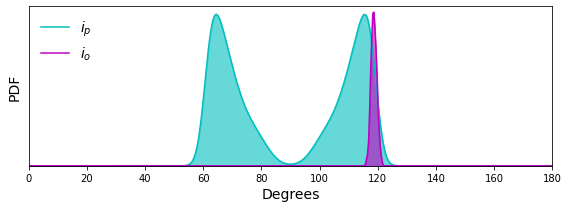

In [20]:
# number of points
nv     = 500

##########################################################################################
# inclination orbit
io     = np.random.normal(loc=VHS_inc_o, scale=1, size=nv)
pdf_io = kde.KDE1D(io, lower=0., upper=180) # PDF of io

##########################################################################################
# inclination planet
angles = np.linspace(0, np.pi, nv)
vrange = np.linspace(0, prior_v.max().value, nv)
cosirange = np.linspace(0, 1, nv)

pdf_lv = kde.KDE1D(prior_v.value, lower=0 , upper=50)
pdf_lu = kde.KDE1D(prior_vsini.value, lower=0 , upper=50)
pdf_Pv = kde.KDE1D(vrange, lower=0 , upper=50)
pdf_Pcos = kde.KDE1D(cosirange, lower=0 , upper=90)




angles, pcosi, curve_pcosi = planet_inclination(pdf_lu, pdf_lv, pdf_Pv, pdf_Pcos,nv=nv)

ip_pcosi = np.arccos(curve_pcosi)
#ip_pcosi = np.concatenate((ip_pcosi, np.pi-ip_pcosi))
# PDF of ip
#eq_ip  = pcosi*np.sin(angles) 
#int_ip  = np.trapz(eq_ip, angles) # normalization factor
#eq_ip /= int_ip


sample = (prior_vsini < prior_v)
nsample = np.sum(sample)
print(f"Size initial sample = {len(prior_v)}")
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = prior_vsini.value/prior_v.value
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip, np.pi-ip))
nsample *= 2

pdf_ip = kde.KDE1D(ip, lower=0., upper=2*np.pi, method=kde_methods.cyclic) # PDF of io



##########################################################################################
# THE FIGURE io & ip
##########################################################################################
plt.figure(figsize=(8,3))
##############################

# pdf of the planet's inclination
complete_ip = np.concatenate((curve_pcosi[::-1], curve_pcosi))
complete_angles = np.linspace(0, 180, len(complete_ip))
plt.plot(complete_angles,complete_ip *280, label=r'$i_p$', color='c')
plt.fill_between(complete_angles,0,complete_ip *280, color='c', alpha=0.6)


# pdf of the orbit's inclination 
plt.plot(angles*180/np.pi, pdf_io(angles*180/np.pi), label=r'$i_o$', color='m')
plt.fill_between(angles*180/np.pi,0, pdf_io(angles*180/np.pi), color='m', alpha=0.6)


# adjusting the plot 
plt.ylabel('PDF',fontsize=14)
plt.xlabel(r'Degrees',fontsize=14)
#plt.tick_params(direction='in')
plt.xlim(0,180)
plt.ylim(0,0.4)
plt.yticks([], [])

plt.legend(frameon=False,fontsize=14, loc=2)
plt.tight_layout()
plt.savefig('inc_op.pdf')
plt.show()


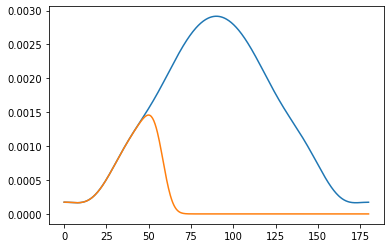

In [65]:
plt.plot(angles*180/np.pi,pcosi)

ip_pcosi = np.arccos(curve_pcosi)
plt.plot(angles*180/np.pi,curve_pcosi)
#plt.plot(ip_pcosi)

#np.arccos(pcosi)

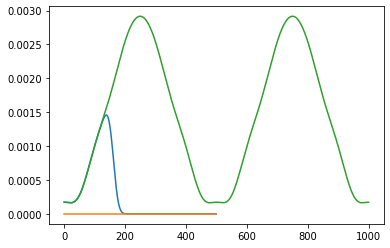

In [66]:
#ip_pcosi+ip_pcosi
curve_pcosi_complete = np.concatenate((np.abs(-pcosi),pcosi))
#plt.plot(ip_pcosi)
plt.plot(curve_pcosi)
plt.plot(-curve_pcosi+curve_pcosi)
plt.plot(curve_pcosi_complete)

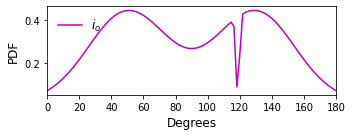

In [83]:
###############
proj_ob = np.abs(pdf_io(angles*180/np.pi)-pdf_ip(angles))


plt.figure(figsize=(5,2))


plt.plot(angles*180/np.pi, proj_ob, label=r'$i_o$', color='m')

plt.legend(frameon=False,fontsize=12, loc=2)
plt.ylabel('PDF',fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
#plt.tick_params(direction='in')
plt.xlim(0,180)
#plt.ylim(-0.01,0.13)
plt.tight_layout()
plt.savefig('inc_op.pdf')
plt.show()



In [26]:

def phi_op_dist(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)
    
    dist_1 = arg_2*np.cos(Omega_orb-Omega_pl)
    
    phi_op = np.arccos(arg_1 + dist_1)
    return phi_op


conv = np.pi/180

l = np.linspace(0, np.pi, 200)
inc_orbit = 90*conv #pio(l) # ±12
Omega_orb = 38 #218+-10 ± 180
Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=100000)
inc_planet = pdf_ip(angles)
phi_op = phi_op_dist(inc_planet[0]*conv, inc_orbit, Omega_pl_dist*conv, Omega_orb*conv)



# plot projected obliquity
plt.figure(figsize=(5,2))


####
plt.plot(l/dr, pl*dr*4, label=r"$|i_{\rm p} - i_{\rm o}|$", color='c')
#plt.plot(l/dr,pio(l/dr)*0.1, label="inc orit")

#plt.hist(phi_op/conv, bins=100, density=True,range=(0,180), label=r'$\Psi_{op}$', color='m',histtype='step')
ohi_op_den = kde.KDE1D(phi_op, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io
#plt.plot(l/dr,ohi_op_den(l)*0.1, color='m', label=r'$\Psi_{op}$')



plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.ylabel("PDF",fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
plt.tick_params(direction='in')
plt.xlim(0,180)
plt.ylim(-0.01,0.12)
plt.legend(frameon=False,fontsize=12,loc=9)
plt.tight_layout()
plt.savefig('obl_op.pdf')
plt.show()

NameError: name 'pl' is not defined

<Figure size 360x144 with 0 Axes>

In [28]:
lo(io)*10000, io

(array([3893.67479257,  833.20868221, 3244.51617355, 3935.56855206,
        3925.20448688, 3658.84880971, 1101.87306594, 2877.1782333 ,
         469.78030386, 3071.72111909, 3669.07300724, 3475.2085567 ,
         887.33170695, 1888.39488321, 1067.92010234, 3933.52264664,
        1232.13486838, 3288.82446171,  428.56300114, 3873.912676  ,
        3596.94784272, 3110.982676  , 3500.26849127, 3290.53345632,
        3700.90148035,  700.18647491, 3924.53587084, 3716.57983344,
        3933.21863447, 3641.92572396, 2805.10969269, 3927.28319313,
         710.97160957, 2472.89702082, 1899.70692421, 3587.02772127,
        3905.12574973, 3648.19177246, 2205.20047368, 3020.95032476,
          37.09280681, 3559.64242751, 3952.78241834, 3920.31673536,
        1877.84609787,  742.40431241, 3583.44969344, 2256.57733091,
        2799.96274224, 3688.10363458, 3940.98279565, 3453.97632296,
        3725.94730724, 3950.33839547, 3949.77842802, 3621.31462398,
        2192.28023646, 3518.95699259, 3776.69744

In [48]:
######################## ########################
################################################




def phi_op_dist(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)
    
    dist_1 = arg_2*np.cos(Omega_orb-Omega_pl)
    
    phi_op = np.arccos(arg_1 + dist_1)
    return phi_op


conv = np.pi/180

l = np.linspace(0, np.pi, 200)
inc_orbit = 90*conv #pio(l) # ±12
Omega_orb = -5 #± 13 ± 180
Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=100000)
phi_op = phi_op_dist(inc_planet[0]*conv, inc_orbit, Omega_pl_dist*conv, Omega_orb*conv)



# plot projected obliquity
plt.figure(figsize=(5,2))


####
plt.plot(l/dr, pl*dr*4, label=r"$|i_{\rm p} - i_{\rm o}|$", color='c')
#plt.plot(l/dr,pio(l/dr)*0.1, label="inc orit")

#plt.hist(phi_op/conv, bins=100, density=True,range=(0,180), label=r'$\Psi_{op}$', color='m',histtype='step')
ohi_op_den = kde.KDE1D(phi_op, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io
plt.plot(l/dr,ohi_op_den(l)*0.1, color='m', label=r'$\Psi_{op}$')



plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.ylabel("PDF",fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
plt.tick_params(direction='in')
plt.xlim(0,180)
plt.ylim(-0.01,0.12)
plt.legend(frameon=False,fontsize=12,loc=9)
plt.tight_layout()
plt.savefig('obl_op.pdf')
plt.show()

NameError: name 'inc_planet' is not defined